In [2]:
#import libraries
'''shell
pip install pandas_datareader
pip install keras
pip install tensorflow
pip install -U scikit-learn scipy matplotlib
pip install yfinance
'''
import random
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import datetime
from keras.layers import Dense, Activation ,Dropout , Flatten , Conv1D , MaxPooling1D

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,LSTM,Input,Reshape
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf

plt.style.use('default')

2023-07-26 13:35:42.071467: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
end = datetime.date.today()-datetime.timedelta(7)
start = datetime.date(2012,1,1)
df1 = yf.download('SPY',start='2010-01-01',end=end)


[*********************100%***********************]  1 of 1 completed


In [4]:
columns_to_drop = ['Open','High','Low','Adj Close','Volume']
df1 = df1.drop(columns = columns_to_drop)
df_shifted = df1.shift(-1)
df_shifted2 = df_shifted.shift(-1)







In [49]:
data = df1
#created shifted data
shifted_data = df_shifted

input_dim = 6
dataset = data.values
shift_dataset = shifted_data.values
shift2_dataset = df_shifted2.values
dataset=dataset[:-2]
shift_dataset = shift_dataset[:-2]
shift2_dataset = shift2_dataset[:-2]

return_dataset = (shift_dataset-dataset)
return_mx = max(return_dataset)
return_mn = min(return_dataset)
return_dataset = (return_dataset-return_mn)/(return_mx-return_mn)
 #because the last value of df_shifted will be NaN, so we remove one from dataset as well to equal the length
return2_mx = max(shift2_dataset)
return2_mn = min(shift2_dataset)
shifted2_dataset = (shift2_dataset-dataset-return2_mn)/(return2_mx-return2_mn)
mn=min(dataset)
mx=max(dataset)
data_range = mx-mn
dataset = (dataset-mn)/data_range
shift_dataset = (shift_dataset-mn)/data_range




def turn_into_arr(datas):
    return np.array(datas)
dataset = turn_into_arr(dataset)
shift_dataset = turn_into_arr(shift_dataset)
return_dataset = turn_into_arr(return_dataset)
shift_dataset = turn_into_arr(shift_dataset)

def split_into_sequences(input_dim,datas): #split dataset into sequences of length input dim
    x,y=[],[]
    for i in range(input_dim+1,len(datas)):
        x.append(datas[i-input_dim-1:i-1,0])
        y.append(datas[i-1:i+1,0])
    return(x,y)

def train_split(arr): #convert data into training data
    return (np.array(arr[:math.ceil(0.9*len(arr))]))
def test_split(arr):
    return (np.array(arr[math.ceil(0.9*len(arr)):]))

def assemble(input_dim,datas): #main fnc
    orig = split_into_sequences(input_dim,datas)
    x_ORIG,y_ORIG = orig[0],orig[1]
     #up to 3387
    #order of shuffling
    
  
    x_fin,y_fin=train_split(x_ORIG),train_split(y_ORIG)
    x_t,y_t=test_split(x_ORIG),test_split(y_ORIG)
    return(x_fin,y_fin,x_t,y_t)



orig_train = assemble(6,dataset) #1st input dimension, true data values
x_orig , y_orig = orig_train[0],orig_train[1]
x_test_orig , y_test_orig = orig_train[2] , orig_train[3]

shift_train = assemble(6,shift_dataset) #not an input dimension, just to test that return_train matches orig_train
x_shift , y_shift = shift_train[0],shift_train[1]

return_train = assemble(6,return_dataset)#2nd input dimension, return data values
x_ret , y_ret = return_train[0],return_train[1]
return_test_x , return_test_y = return_train[2],return_train[3]

rr_train = assemble(6,shifted2_dataset)
x_rr , y_rr = rr_train[0],rr_train[1]
rr_test_x , rr_test_y = rr_train[2], rr_train[3]



x_train = np.stack([x_orig,x_ret],axis=2)
y_train = np.stack([y_orig,y_ret],axis=2)
x_test = np.stack([x_test_orig,return_test_x],axis=2)
y_test = np.stack([y_test_orig,return_test_y],axis=2)

y_test = y_test[:,0,0]
y_test = y_test.reshape(-1,1)

#x_train[:,:,0] corresponds to the original data
#x_train[:,:,1] corresponds to the return data

print(x_train.shape)
print(y_train.shape)

(3059, 6, 2)
(3059, 2, 2)


In [6]:
#Lets Build the lstm model
model = Sequential()
layer = 128
layer2 = 32
# model.add(LSTM(layer,return_sequences=True, input_shape= (x_train.shape[1],1)))
# model.add(LSTM(layer,return_sequences= False))
# model.add(Dense(layer2))
# model.add(Dense(layer2))
# model.add(Dense(1))
model = Sequential()
model.add(Input(shape=(6,2)))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(16, activation="relu", kernel_initializer="uniform"))
model.add(Dense(4, activation="relu", kernel_initializer="uniform"))
model.add(Reshape(target_shape=(2,2)))


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 128)            67072     
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
 reshape (Reshape)           (None, 2, 2)              0         
                                                                 
Total params: 88276 (344.83 KB)
Trainable params: 88276 (344.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
def loss_mse(y_true,y_pred):
    mse_res = tf.reduce_mean(tf.math.squared_difference(y_true[:,0,0],y_pred[:,0,0]))+tf.reduce_mean(tf.math.squared_difference(y_true[:,1,0],y_pred[:,1,0])) + tf.reduce_mean(tf.math.squared_difference(y_true[:,0,1],y_pred[:,0,1])) + tf.reduce_mean(tf.math.squared_difference(y_true[:,1,1],y_pred[:,1,1])) 
    return mse_res
    
def loss_D1(y_true,y_pred):
  return_l = tf.reduce_mean(tf.math.squared_difference((y_true[:,1,0]*(data_range)-y_pred[:,0,0]*(data_range)-return_mn)/(return_mx-return_mn),y_true[:,0,1]))
  return(return_l)

def real_loss(y_true,y_pred):
  final =loss_mse(y_true,y_pred)+loss_D1(y_true,y_pred)
  return final


In [40]:
from tensorflow import keras
from tensorflow.keras import layers
#compile the model
opt = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=opt,loss=real_loss, metrics = ['mae',loss_D1,loss_mse])
epoch = 500
batch_size1=32
history  = model.fit(x_train,y_train, batch_size=batch_size1,epochs=epoch) 

Epoch 1/500
96/96 [==============================] - 7s 11ms/step - loss: 0.0057 - mae: 0.0172 - loss_D1: 2.1753e-04 - loss_mse: 0.0055
Epoch 2/500
96/96 [==============================] - 1s 10ms/step - loss: 0.0055 - mae: 0.0170 - loss_D1: 9.1974e-06 - loss_mse: 0.0055
Epoch 3/500
96/96 [==============================] - 1s 10ms/step - loss: 0.0055 - mae: 0.0170 - loss_D1: 1.0988e-05 - loss_mse: 0.0054
Epoch 4/500
96/96 [==============================] - 1s 10ms/step - loss: 0.0055 - mae: 0.0170 - loss_D1: 1.1440e-05 - loss_mse: 0.0055
Epoch 5/500
96/96 [==============================] - 1s 13ms/step - loss: 0.0055 - mae: 0.0170 - loss_D1: 1.6554e-05 - loss_mse: 0.0055
Epoch 6/500
96/96 [==============================] - 1s 11ms/step - loss: 0.0055 - mae: 0.0171 - loss_D1: 1.9824e-05 - loss_mse: 0.0055
Epoch 7/500
96/96 [==============================] - 1s 11ms/step - loss: 0.0055 - mae: 0.0171 - loss_D1: 2.3782e-05 - loss_mse: 0.0055
Epoch 8/500
96/96 [=============================

[7.56111789]


In [41]:
model.save_weights('./checkpoints/test_checkpoint_1')


In [121]:
#model.reset_states()

In [42]:
model.load_weights('./checkpoints/test_checkpoint_1')

In [108]:
y_test = (y_test-mn)/(data_range)

In [125]:
y_test = y_test*(data_range)+mn
print(y_test[105:110])

[412.98987069 411.34962645 419.98993947 419.98993947 427.09992341]


In [109]:
predictions = model.predict(x_test)
predictions = predictions*(data_range)+mn
predictions = predictions[:,0,0]

y_test = y_test*(data_range)+mn


print(tf.reduce_mean(tf.math.squared_difference(predictions,y_test)))

def success_rate(pred,test):
    ctr,ctr1 = 0,0
    for i in range(len(pred)-1):
        if pred[i+1]-pred[i] >= 0 and test[i+1]-test[i] >= 0:
            ctr += 1
        elif pred[i+1]-pred[i] <= 0 and test[i+1]-test[i] <= 0:
            ctr += 1
        else:
            print(pred[i+1],pred[i],test[i+1],test[i],i)
        ctr1 += 1
    return (ctr*100/(len(pred)-1))
percentage_success = success_rate(predictions,y_test)
print(percentage_success)





11/11 [==============================] - 0s 6ms/step
tf.Tensor(163647.17520706155, shape=(), dtype=float64)
100.0


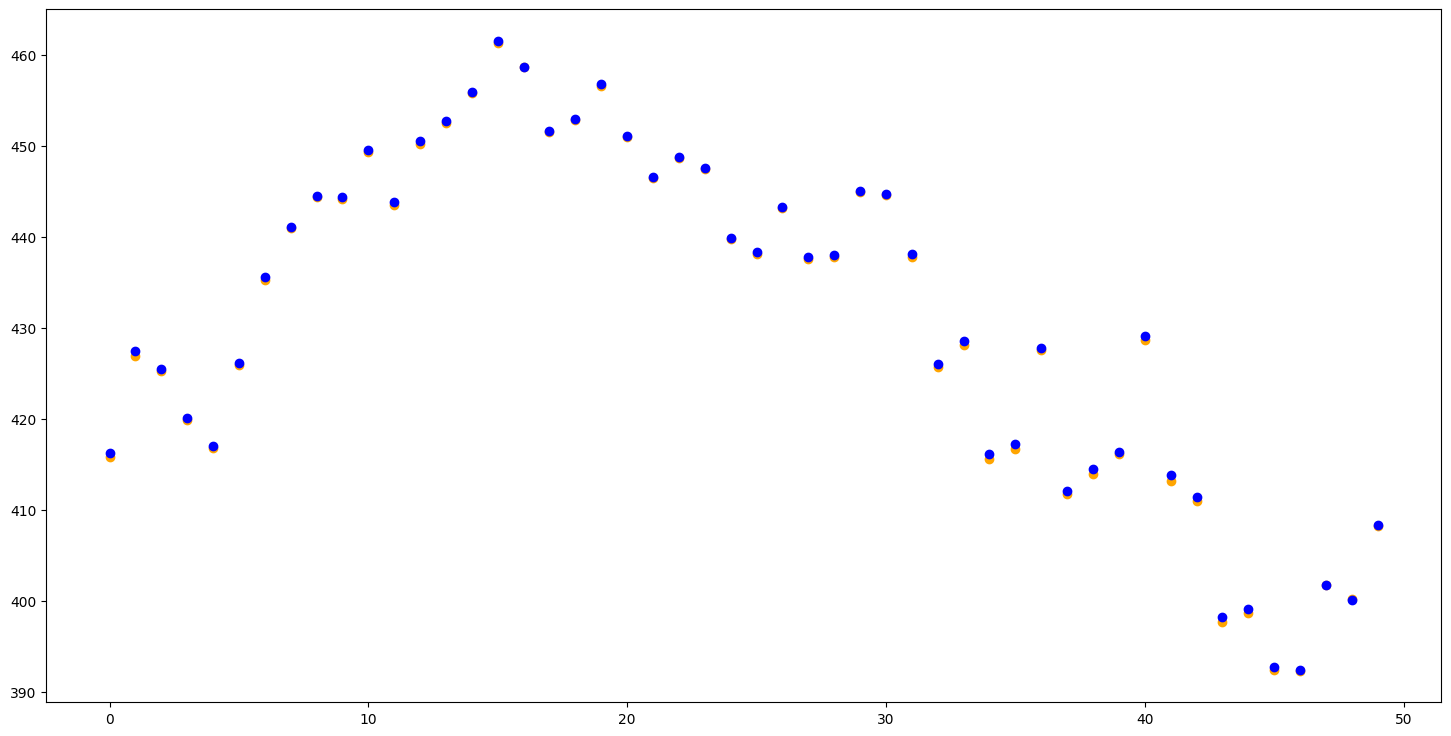

In [46]:
plt.figure(figsize=(18,9))

plt.scatter([i for i in range(50)],predictions[:50].reshape(-1,1),label='pred',color='orange')
plt.scatter([i for i in range(50)],y_test[:50].reshape(-1,1),label='orig',color='blue')
plt.show()

plt.show()

In [128]:
#How much money can I make using this following strategy?
#The strategy is as follows: If I am currently not holding any shares, and I predict that the stock price will increase the following day
#Buy one share
#If I am currently holding a share, and predict that the stock price will increase the following day, hold the share.
#If I am not holding a share, and I predict that the stock price will decrease the following day, sell short one share.
#If I am currently holding a short, and predict that the stock price will decrease the following day, hold my sell short
#If I am currently holding a short, and predict that the stock price will increase the following day, return my share and buy one share.
#If I am currently holding a share, and predict that the stock price will decrease the following day, sell the share and sell short. 
bank_balance = 1000
share_status = 0 #denote a share status of 1 as 1 share, 0 as none, -1 as a short
def trade(pred,bal,share_status):
    for i in range(21):
        if pred[i+1]>y_test[i] and share_status == 0:
            share_status = 1
            bal -= y_test[i]
            print(bal,'1')
        elif pred[i+1]<y_test[i] and share_status == 0:
            share_status = -1
            bal += y_test[i]
            print(bal,'2')
        elif pred[i+1]<y_test[i] and share_status == -1:
            print(bal,'3')
        elif pred[i+1]>y_test[i] and share_status == -1:
            bal -= 2*y_test[i]
            share_status = 1
            print(bal,'4')
        elif pred[i+1]<y_test[i] and share_status == 1:
            bal += 2*y_test[i]
            share_status = -1
            print(bal,'5')
    if share_status == 1:
        bal += y_test[i]
        print(bal,'6')
    if share_status == -1:
        bal -= y_test[i]
        print(bal,'7')
    return bal

res = trade(predictions,1000,0)
print(res)
            
        



583.7499858945546 1
1438.5697637654785 5
1438.5697637654785 3
1438.5697637654785 3
604.569357488665 4
1493.6090585218976 5
604.8287447606764 4
1504.0082896085576 5
616.408500282215 4
1539.5076318156825 5
1539.5076318156825 3
636.2281836757637 4
1549.8283118646586 5
1549.8283118646586 3
1098.7980633841457 7
1098.7980633841457


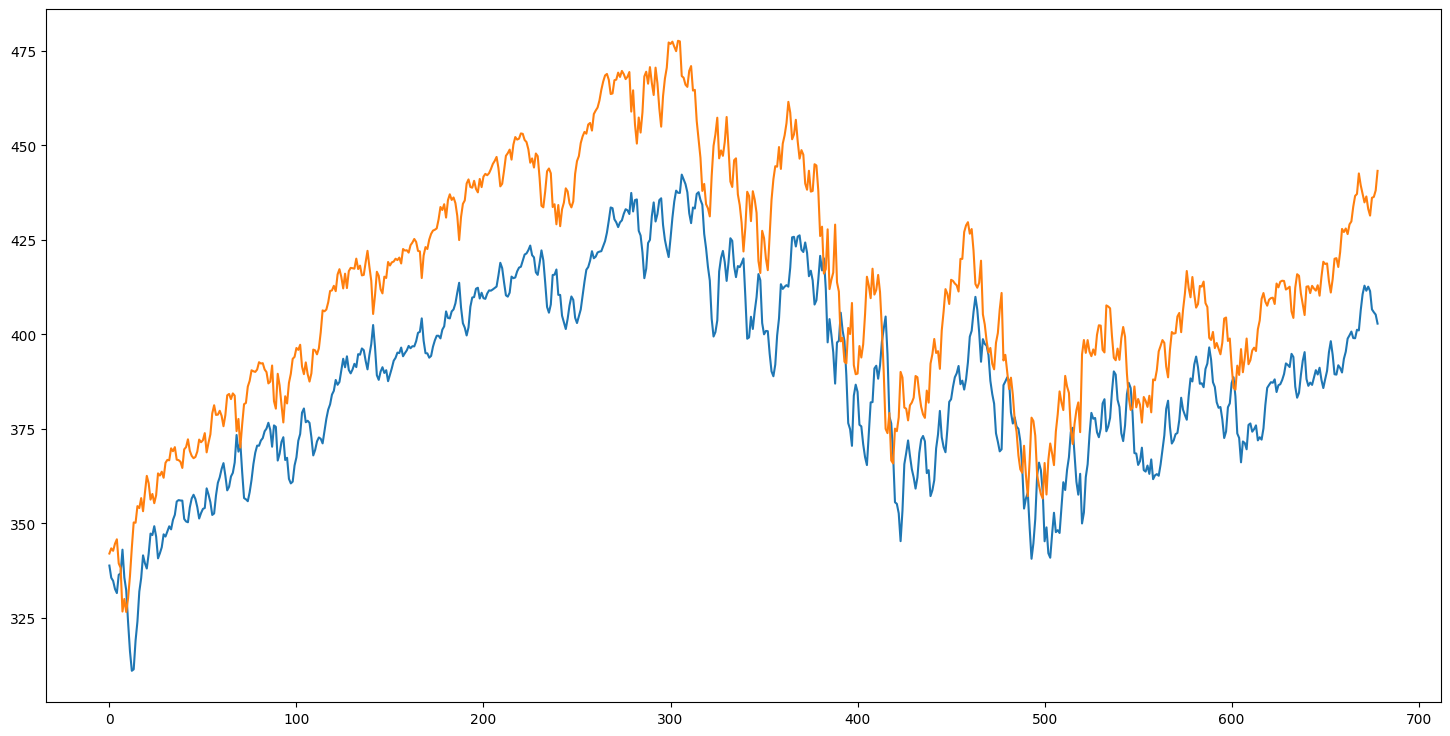

In [495]:
plt.figure(figsize=(18,9))

plt.plot([i for i in range(len(prediction[0]))],prediction.reshape(-1,1),label='pred')
plt.plot([i for i in range(len(prediction[0]))],y_test_final.reshape(-1,1),label='orig')
plt.show()


In [ ]:
hist = pd.DataFrame(history.history)
hist

NameError: name 'history' is not defined

NameError: name 'history' is not defined

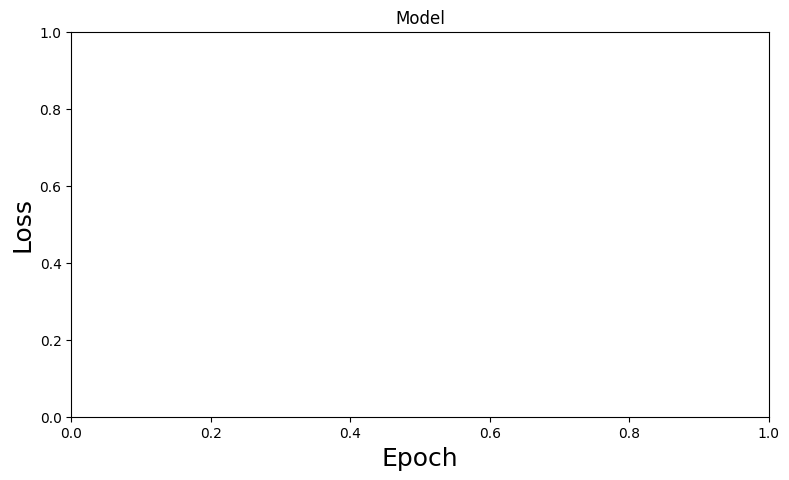

In [ ]:
plt.figure(figsize=(9,5))
plt.title('Model')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.plot(history.history['loss'][10:])
#start with tenth
plt.plot(history.history['val_loss'][10:])
plt.ylim([0,0.02])
plt.legend(['Train_loss','val_loss'], loc= 'best')
plt.show()

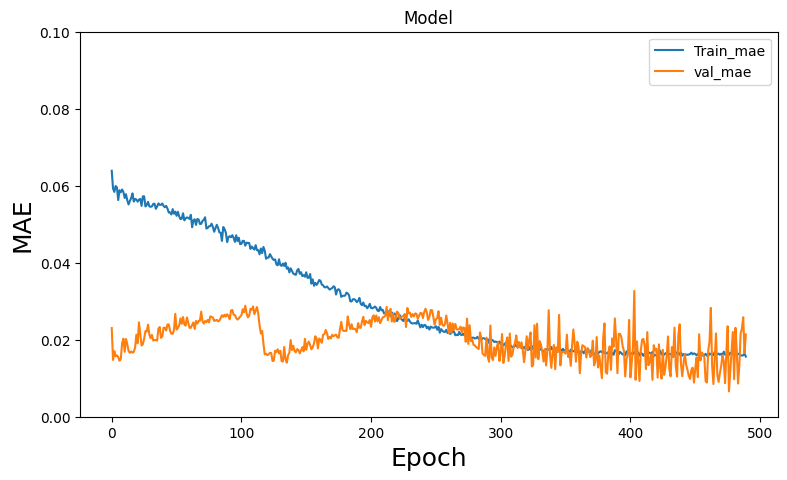

In [46]:
plt.figure(figsize=(9,5))
plt.title('Model')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('MAE', fontsize=18)
plt.plot(history.history['mae'][10:])
plt.plot(history.history['val_mae'][10:])
plt.ylim([0,0.1])
plt.legend(['Train_mae','val_mae'], loc= 'best')
plt.show()



          loss       mae    loss_D  loss_mse  val_loss   val_mae  val_loss_D  \
495  0.000508  0.015904  0.000019  0.002466  0.000566  0.021587    0.000025   
496  0.000493  0.015885  0.000019  0.002391  0.000664  0.022913    0.000025   
497  0.000499  0.015969  0.000019  0.002422  0.000781  0.025835    0.000025   
498  0.000543  0.016371  0.000019  0.002637  0.000372  0.016601    0.000025   
499  0.000457  0.015630  0.000019  0.002211  0.000576  0.021371    0.000024   

     val_loss_mse  epoch  
495      0.002730    495  
496      0.003221    496  
497      0.003807    497  
498      0.001759    498  
499      0.002783    499  


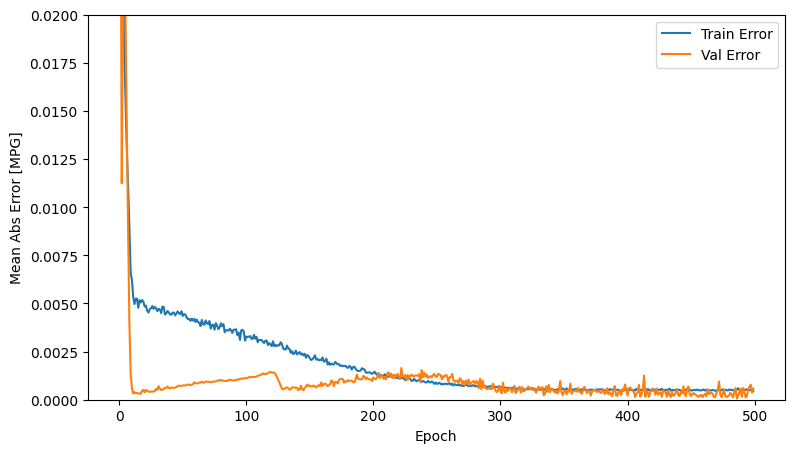

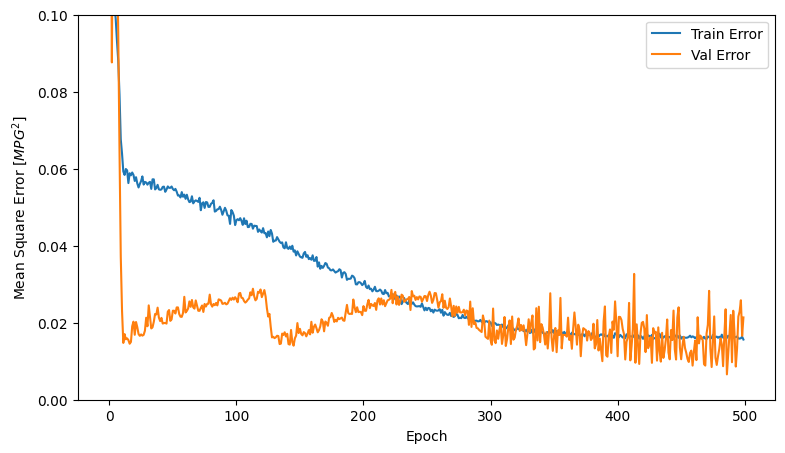

In [47]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print('\n', hist.tail())

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(9,5))
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['loss'
    ],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
    plt.ylim([0,0.020])
    plt.legend()

    plt.figure(figsize=(9,5))
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.ylim([0,0.1])
    plt.legend()
    plt.show()


plot_history(history)

# 495  0.001815  0.031789  0.000016  0.003312    495
# 496  0.001812  0.032097  0.000065  0.007149    496
# 497  0.001848  0.032512  0.000042  0.005849    497
# 498  0.001946  0.032696  0.000006  0.001849    498
# 499  0.001653  0.030877  0.000044  0.006065    499



['loss', 'mae']

In [60]:
def mse_eval(y_true,y_pred):
    return (y_true[:,0,0]-y_pred[:,0,0])**2




In [59]:
#rewrite eval code
model.compile(optimizer = opt, loss = mse_eval)
model.evaluate(x_train_final,y_train_final)

73/73 [==============================] - 1s 4ms/step - loss: 9.2468e-05


9.246778063243255e-05

In [497]:
#plot the prediction
plt.figure(figsize = (18,9))
x_coords = []
y_test = y_test[:-1]
predictions = model.predict(x_test_final)

#predictions = scaler.inverse_transform(predictions[:,0,0].reshape(1,-1))
#print(predictions[0])
#print(len(predictions[0]))
predictions = predictions[:,0,0]
temp_y = y_test_final[:,0,0]
print(x_test_final[:4],"!")
predictions1 = scaler.inverse_transform(predictions.reshape(1,-1))
temp_y=scaler.inverse_transform(temp_y.reshape(1,-1))
mse_test = tf.reduce_mean(tf.math.squared_difference(predictions1[:],temp_y[:]))
rmse_test = math.sqrt(mse_test)  
unscaled_mse_test = tf.reduce_mean(tf.math.squared_difference(predictions[:],y_test_final[:,0,0][:]))
unscaled_rmse_test = math.sqrt(unscaled_mse_test)
print(mse_test)
for i in range(len(predictions1[0])):
    x_coords.append(i)
print(predictions[:5])
plt.plot(x_coords,predictions1[0],label="Predicted")

plt.plot([x for x in x_coords],temp_y[0],label="True")
plt.legend()
#plt.plot(x_coords,predictions1)
#plt.plot(x_coords,y_test_final[:,0,0])
plt.show()

22/22 [==============================] - 0s 8ms/step


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

<Figure size 1800x900 with 0 Axes>

In [ ]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error

#create Testing dataset
#create a new array containing scaled values from index 1677 till 2171
#test_data= scaled_data[training_data_len-input_dim: , :] 
#Lets create x_test and y_test dataset
#x_test=[]
#y_test= dataset[training_data_len:,:]
#for i in range(input_dim, len(test_data)):
    #x_test.append(test_data[i-input_dim:i,0])

  
    
#CConvert a numpy array of x_test
#x_test= np.array(x_test)
#x_test.shape

#lets reshape the data
#x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
#x_test.shape


#Get models predicted price values
#predictions = model.predict(x_test)
#predictions = scaler.inverse_transform(predictions)
#predictions2 = model.predict(x_train)
#predictions2 = scaler.inverse_transform(predictions2)
#y_train2=scaler.inverse_transform(y_train.reshape(-1, 1))

#temp = np.zeros(input_dim) + np.nan
#pred2= np.insert(pred2, np.zeros(60) + np.nan)
#pred2=np.append(temp,predictions2)

#plot the data
#train = data[:training_data_len]
#valid = data[training_data_len:]
#valid['Predictions'] = predictions
#train['Predictions2'] = pred2


plt.figure(figsize = (18,9))
plt.plot(train['SMA20'], color = 'black',  lw=1, label = ' Training_Stock Price')
plt.plot(train['Predictions2'], color = 'orange', label = 'Predicted training_Stock  Price', lw=2, alpha=0.9)
plt.title('Training Stock Price Prediction', fontsize=30)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('STock Price')
#plt.ylim([0,15])
plt.legend(fontsize=18)
plt.show()



plt.figure(figsize = (18,9))
plt.plot(valid['SMA20'], color = 'black',  lw=1, label = ' Test_Stock Price')
plt.plot(valid['Predictions'], color = 'orange', label = 'Predicted Test_Stock  Price', lw=2, alpha=0.99)
plt.title('Test Stock Price Prediction', fontsize=30)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('STock Price')
#plt.ylim([0,5])
plt.legend(fontsize=18)
plt.show()

mse_test = tf.reduce_mean(tf.math.squared_difference(predictions[:],y_test[:]))
rmse_test = math.sqrt(mse_test)      
mae_test = mean_absolute_error(predictions[:],y_test[:])
mape_test = mean_absolute_percentage_error(predictions[:],y_test[:])

mse_train = tf.reduce_mean(tf.math.squared_difference(predictions2[:],y_train2[:]))
rmse_train = math.sqrt(mse_train) 
mae_train = mean_absolute_error(predictions2[:],y_train2[:])

print("Test RMSE: %0.15f" %rmse_test)
print("Train RMSE: %0.15f" %rmse_train)

ValueError: in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py", line 2283, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_1' (type Sequential).
    
    Input 0 of layer "lstm" is incompatible with the layer: expected shape=(None, None, 3), found shape=(None, 5, 1)
    
    Call arguments received by layer 'sequential_1' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 5, 1), dtype=float32)
      • training=False
      • mask=None


In [ ]:

trainScore = math.sqrt(mean_squared_error(train['SMA20'][input_dim:], train['Predictions2'][input_dim:]))
print('Train Score: RMSE' , trainScore)

testScore = math.sqrt(mean_squared_error(valid['SMA20'], valid['Predictions']))
print('Test Score: RMSE' , (testScore))


Train Score: RMSE 2.2482038815603437e-05
Test Score: RMSE 1.789715736758164e-05


In [ ]:
output=[]
temp =[input_dim,batch_size1,epoch,rmse_train,mae_train,rmse_test,mae_test,mape_test]
output.append(temp)
name = ['input_dim','batch_size','epoch','rmse_train','mae_train','rmse_test','mae_test','mape_test']
table = pd.DataFrame(output)
table.columns = name

table
#5 is better than 20 and 60



,input_dim,batch_size,epoch,rmse_train,mae_train,rmse_test,mae_test,mape_test
0,5,128,500,0.000022,0.000019,0.000018,0.000015,0.00669


In [ ]:
#table.to_html('temp1.html')

1/1 [==============================] - 0s 28ms/step


TypeError: Slicing a positional slice with .loc is not allowed, Use .loc with labels or .iloc with positions instead.

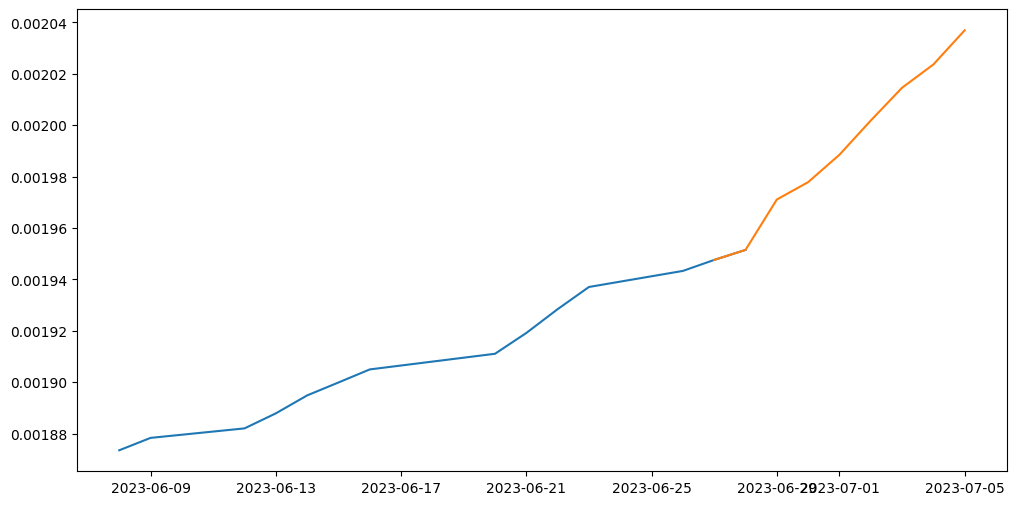

In [ ]:
#Future Prediction
prediction = [] #Empty list to populate later with predictions

current_batch = test_data[-x_train.shape[1]:] #Final data points in train ?????????????????????
current_batch = current_batch.reshape(1, x_train.shape[1],1) #Reshape

## Predict future, beyond test dates
future = 7 #Days
lookback = 21 #how many days to lookback
same_range = 2 #show common data range


for i in range(future):
    current_pred = model.predict(current_batch)[0]
    prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

### Inverse transform to before scaling so we get actual numbers
rescaled_prediction = scaler.inverse_transform(prediction)


test=data.iloc[training_data_len:] 
time_series_array = test.index  #Get dates for test data

#Add new dates for the forecast period
for k in range(0, future):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))

#Create a dataframe to capture the forecast data
df_forecast = pd.DataFrame(columns=["actual_confirmed","predicted"], index=time_series_array)

df_forecast.predicted.iloc[-future:] = rescaled_prediction[:,0]
df_forecast.predicted.iloc[-future-same_range:-future] = valid["SMA20"][-same_range:]

df_forecast.loc[:,"actual_confirmed"] = valid["SMA20"]



# Plot
plt.figure(figsize = (12,6))
#plt.plot(df_forecast.predicted[-future-1:],label = 'Predicted Stock Price')
plt.plot(df_forecast[-lookback:],label = 'Stock Price')



#plot ‘buy’ signals
df_forecast['Signal'] = 0.0
for i in range(-future-same_range+1,0):
    if df_forecast.predicted[i] < df_forecast.predicted[i-1]:
        df_forecast.loc[i:,'Signal'] = 0
    else:
        df_forecast.loc[i:,'Signal'] = 1
df_forecast['Position'] = df_forecast['Signal'].diff()
plt.plot(df_forecast[df_forecast['Position'] == 1].index, 
         df_forecast['predicted'][df_forecast['Position'] == 1], 
          '^', markersize = 15, color = 'g', label = 'BUY')
#plot ‘sell’ signals
plt.plot(df_forecast[df_forecast['Position'] == -1].index, 
          df_forecast['predicted'][df_forecast['Position'] == -1], 
          'v', markersize = 15, color = 'r', label = 'SELL')





plt.title('Future Week Price Prediction', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(rotation = 45)
plt.ylabel('STock Price', fontsize=14)
plt.legend(['Stock Ratio Price', 'Predicted Stock Ratio Price','Buy','Sell'],fontsize=12)

In [ ]:
df_forecast[-lookback:]